Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


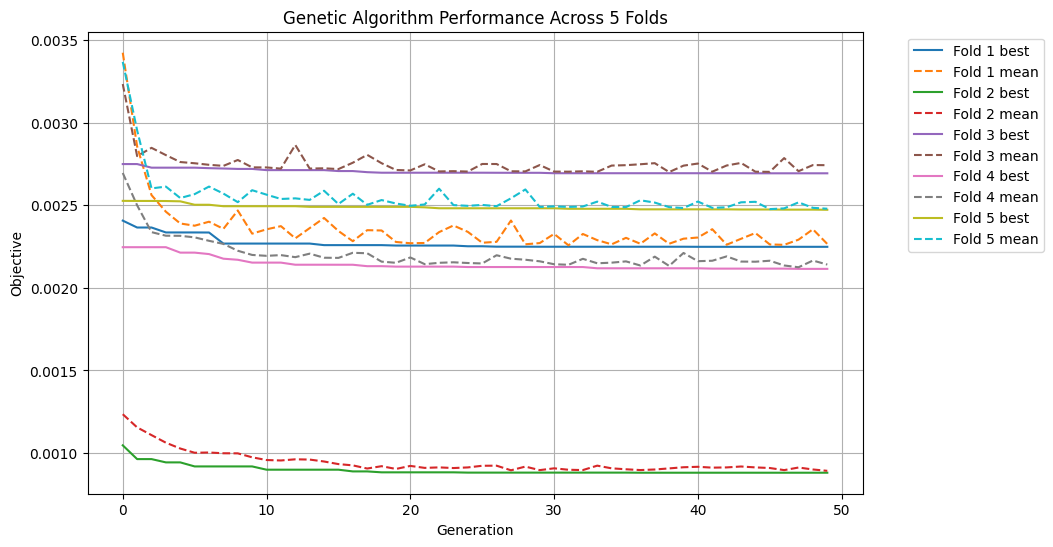

Mean Absolute Error: 0.028026941706038443
Root Mean Squared Error: 0.039989416927327215
R2: 0.12158721463659561


Actual  Predicted
0  0.004571   0.010905
1  0.083300   0.072792
2  0.002550  -0.029550
3  0.019841   0.042970
4  0.012600  -0.017108

In [2]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Load the main filled data file
data = pd.read_csv('/content/drive/MyDrive/Sai_Chem_Endsem/data.csv')

# Load the descriptor files
solute_descriptors = pd.read_csv('/content/drive/MyDrive/Sai_Chem_Endsem/soldes.csv')
solvent1_descriptors = pd.read_csv('/content/drive/MyDrive/Sai_Chem_Endsem/sv1des.csv')
solvent2_descriptors = pd.read_csv('/content/drive/MyDrive/Sai_Chem_Endsem/sv2des.csv')

# Rename columns to match the main data file
for df in [solute_descriptors, solvent1_descriptors, solvent2_descriptors]:
    df.rename(columns={'System no.': 'System No'}, inplace=True)

# Merge descriptors with the main data
data = data.merge(solute_descriptors, on='System No', suffixes=('', '_solute'))
data = data.merge(solvent1_descriptors, on='System No', suffixes=('', '_solvent1'))
data = data.merge(solvent2_descriptors, on='System No', suffixes=('', '_solvent2'))

# Prepare feature columns
solute_columns = solute_descriptors.columns.difference(['System No']).tolist()
solvent1_columns = solvent1_descriptors.columns.difference(['System No']).tolist()
solvent2_columns = solvent2_descriptors.columns.difference(['System No']).tolist()

features = ['System No', 'x1', 'x2', 'xs1p', 'xs2p', 'Temp'] + solute_columns + [col + '_solvent1' for col in solvent1_columns] + [col + '_solvent2' for col in solvent2_columns]
final_data = data[features + ['Xs_Exper']]

# Save and reload preprocessed data
final_data.to_csv('/content/drive/MyDrive/Sai_Chem_Endsem/processed_data.csv', index=False)
data = pd.read_csv('/content/drive/MyDrive/Sai_Chem_Endsem/processed_data.csv')

# Define features and target
X = data.drop(columns=['Xs_Exper']).values
y = data['Xs_Exper'].values

# Define the genetic algorithm functions
def initialize_population(size, n_features):
    return np.random.randint(0, 2, size=(size, n_features))

def fitness(individual, X, y):
    selected_features = np.where(individual == 1)[0]
    if len(selected_features) == 0:
        return 1e10
    X_selected = X[:, selected_features]
    X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return mean_squared_error(y_test, y_pred)

def select(population, fitnesses, num_parents):
    parents = np.empty((num_parents, population.shape[1]), dtype=int)
    for parent_num in range(num_parents):
        min_fitness_idx = np.argmin(fitnesses)
        parents[parent_num, :] = population[min_fitness_idx, :]
        fitnesses[min_fitness_idx] = 1e10
    return parents

def crossover(parents, offspring_size):
    offspring = np.empty(offspring_size, dtype=int)
    crossover_point = np.uint8(offspring_size[1] / 2)

    for k in range(offspring_size[0]):
        parent1_idx = k % parents.shape[0]
        parent2_idx = (k + 1) % parents.shape[0]
        offspring[k, 0:crossover_point] = parents[parent1_idx, 0:crossover_point]
        offspring[k, crossover_point:] = parents[parent2_idx, crossover_point:]

    return offspring

def mutation(offspring, mutation_rate):
    for idx in range(offspring.shape[0]):
        for _ in range(mutation_rate):
            gene_idx = np.random.randint(0, offspring.shape[1])
            offspring[idx, gene_idx] = 1 if offspring[idx, gene_idx] == 0 else 0
    return offspring

# Parameters
population_size = 20
num_generations = 50
num_parents_mating = 10
mutation_rate = 1
n_features = X.shape[1]

kf = KFold(n_splits=5, shuffle=True, random_state=42)

fold = 1
fold_best_outputs = []
fold_mean_outputs = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    population = initialize_population(population_size, n_features)
    best_outputs = []
    mean_outputs = []

    for generation in range(num_generations):
        fitnesses = np.array([fitness(individual, X_train, y_train) for individual in population])
        best_outputs.append(np.min(fitnesses))
        mean_outputs.append(np.mean(fitnesses))
        parents = select(population, fitnesses, num_parents_mating)
        offspring_crossover = crossover(parents, (population_size - parents.shape[0], n_features))
        offspring_mutation = mutation(offspring_crossover, mutation_rate)
        population[0:parents.shape[0], :] = parents
        population[parents.shape[0]:, :] = offspring_mutation

    fold_best_outputs.append(best_outputs)
    fold_mean_outputs.append(mean_outputs)

    fold += 1

plt.figure(figsize=(10, 6))

for i in range(5):
    plt.plot(fold_best_outputs[i], label=f'Fold {i+1} best')
    plt.plot(fold_mean_outputs[i], linestyle='--', label=f'Fold {i+1} mean')

plt.xlabel('Generation')
plt.ylabel('Objective')
plt.title('Genetic Algorithm Performance Across 5 Folds')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

# Use the best features from GA to train the final Linear Regression model on all data
selected_features = np.where(population[np.argmin([fitness(ind, X, y) for ind in population])] == 1)[0]
X_selected = X[:, selected_features]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

# Train the Linear Regression model
final_model = LinearRegression()
final_model.fit(X_train, y_train)

# Predict on the test set
y_pred = final_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"Mean Absolute Error: {mae}")
print(f"Root Mean Squared Error: {rmse}")
print(f"R2: {r2}")

# Save the predicted values to a CSV file
predicted_data = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
predicted_data.to_csv('/content/drive/MyDrive/Sai_Chem_Endsem/GA_LinAlg.csv', index=False)
preds =  pd.read_csv('/content/drive/MyDrive/Sai_Chem_Endsem/GA_LinAlg.csv')
# Save the final model and selected features
import joblib
joblib.dump(final_model, '/content/drive/MyDrive/Sai_Chem_Endsem/final_linear_model.pkl')
np.save('/content/drive/MyDrive/Sai_Chem_Endsem/selected_features.npy', selected_features)
preds.head()


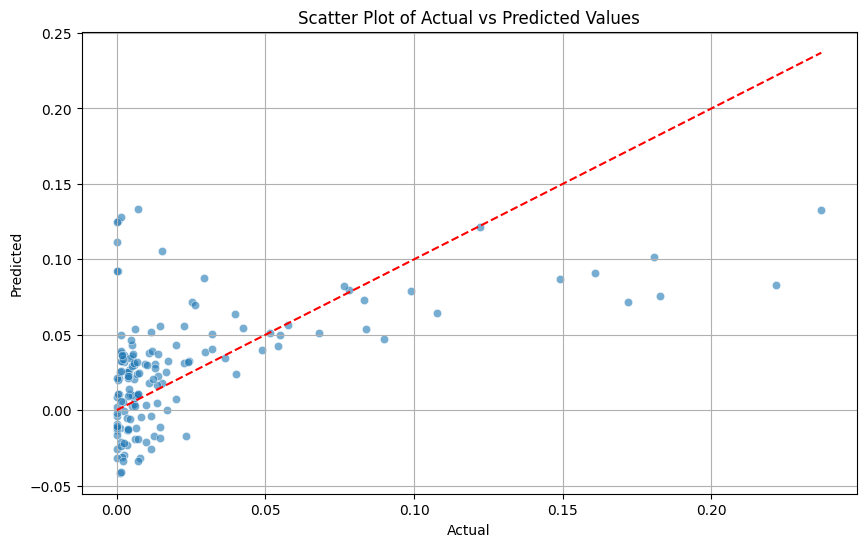

In [3]:
import matplotlib.pyplot as plt
import pandas as pd

# Load the predicted data
predicted_data = pd.read_csv('/content/drive/MyDrive/Sai_Chem_Endsem/GA_LinAlg.csv')

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(predicted_data['Actual'], predicted_data['Predicted'], alpha=0.6, edgecolors='w', linewidth=0.5)
plt.plot([predicted_data['Actual'].min(), predicted_data['Actual'].max()],
         [predicted_data['Actual'].min(), predicted_data['Actual'].max()], 'r--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Scatter Plot of Actual vs Predicted Values')
plt.grid(True)
plt.show()
